This talk uses widgets! Install them (and restart your notebook):

```
conda install -c conda-forge ipywidgets
```

or

```
pip install ipywidgets
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
matplotlib.rc('image', cmap='Greys_r')

from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    '''Helper for less-ugly colorbars on image data with forced-equal axes aspect ratio'''
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

import numpy as np

import os.path
import requests

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as w

import sklearn
from sklearn import decomposition
from sklearn import datasets

from astropy.io import fits

In [2]:
# Olivetti faces dataset
faces = datasets.fetch_olivetti_faces()  # Should take only a few seconds on a home connection

<div style="text-align: center;">
<h1>Dimensionality reduction beyond Principal Components Analysis</h1>
<h2>Joseph Long</h2>
<h3><em>Lecture 13 — Wednesday October 18, 2017</em></h3>
<h3><em>ASTR502 - Data Mining and Machine Learning in Astronomy</em></h3>
</div>

# Nonnegative Matrix Factorization

> Non-negative matrix factorization is distinguished from the other methods by its use of non-negativity constraints. These constraints lead to a parts-based representation because they allow only additive, not subtractive, combinations.

— Lee & Seung. "Learning the parts of objects by non-negative matrix factorization" (Nature, 1999) [doi: [10.1038/44565](https://doi.org/10.1038/44565)]

![Example reconstructing a face image from NMF components](images/lecture13-dimensionality-2/lee-nature-1999-fig1a.png)![Example reconstructing a face image from PCA components](images/lecture13-dimensionality-2/lee-nature-1999-fig1c.png)

(Color scale runs from red at its most negative to black at most positive.)

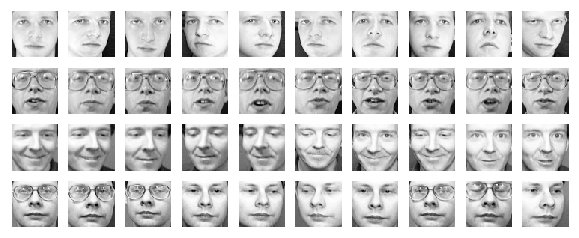

In [3]:
fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(10, 4))
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        ax.imshow(faces['images'][10 * i  + j], cmap='Greys_r')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

*Following Section 7.4 in Ivezić et al.*

Suppose the data matrix $X$ can be expressed as the product of two matrices $W$ and $Y$ where all elements are nonnegative.

$$
    X = W Y
$$

$W$ and $Y$ are chosen to have initially nonnegative values, then updated iteratively according to

\begin{align*}
    W_{ki} \leftarrow W_{ki} \frac{\left[ X Y^{T} \right]_{ki}}{\left[ W Y Y^T \right]_{ki}} &&
    Y_{in} \leftarrow Y_{in} \frac{\left[ W^T X \right]_{in}}{\left[ W^T W Y \right]_{in}} &&
\end{align*}

eventually minimizing the so-called Frobenius norm $||(X - WY)^2||$ (a straightforward generalization of the Euclidean norm to matrices):

$$
    d_{\mathrm{Fro}}(X, Y) = \frac{1}{2} ||X - Y||_{\mathrm{Fro}}^2 = \frac{1}{2} \sum_{i,j} (X_{ij} - {Y}_{ij})^2
$$

(n.b. The text calls $n$, $k$, $i$ the wavelength, spectrum, and template indices in the context of the SDSS galaxy spectrum decomposition problem. For a $n \times k$ array of data of some other kind, call the indices something else appropriate!)

In [4]:
@interact(i=w.IntSlider(value=252, min=0, max=faces['images'].shape[0] - 1, continuous_update=False))
def show_face(i):
    plt.imshow(faces['images'][i], cmap='Greys_r')
    plt.colorbar()

interactive(children=(IntSlider(value=252, continuous_update=False, description='i', max=399), Output()), _dom_classes=('widget-interact',))

In [5]:
# Set up caches to ease interactivity
STRATEGIES = (decomposition.PCA, decomposition.NMF, decomposition.FastICA)
CACHE = {s: {} for s in STRATEGIES}

In [6]:
def decompose(strategy, n_components):
    if n_components not in CACHE[strategy]:
        CACHE[strategy][n_components] = strategy(n_components=n_components)
        CACHE[strategy][n_components].fit(faces['data'])
    return CACHE[strategy][n_components]

In [17]:
@interact(strategy=w.Dropdown(
    options=[('PCA', decomposition.PCA), ('FastICA', decomposition.FastICA), ('NMF', decomposition.NMF)],
    value=decomposition.PCA,
    description='Strategy:',
), n_components=w.IntSlider(value=8, min=1, max=80, continuous_update=False))
def show_components(n_components, strategy):
    cmap = 'Greys_r'
    fitter = decompose(strategy, n_components)
    components = fitter.components_.reshape((n_components,) + faces['images'].shape[1:])
#     cmin, cmax = np.min(components), np.max(components)
    n_per_row = 5
    nrows, ncols = 1 + n_components // n_per_row, min(n_per_row, n_components)
    fig = plt.figure(figsize=(2 * ncols, 1.5 * nrows))
    for i, comp in enumerate(components):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        im = ax.imshow(comp, cmap=cmap) #, vmin=cmin, vmax=cmax)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

interactive(children=(IntSlider(value=8, continuous_update=False, description='n_components', max=80, min=1), Dropdown(description='Strategy:', options=(('PCA', <class 'sklearn.decomposition.pca.PCA'>), ('FastICA', <class 'sklearn.decomposition.fastica_.FastICA'>), ('NMF', <class 'sklearn.decomposition.nmf.NMF'>)), value=<class 'sklearn.decomposition.pca.PCA'>), Output()), _dom_classes=('widget-interact',))

## Compare reconstructions from different representations

In [8]:
@interact(
    n_components=w.IntSlider(value=80, min=1, max=80, continuous_update=False),
    face_id=w.IntSlider(value=252, min=0, max=faces['images'].shape[0] - 1),
)
def reconstruct(face_id, n_components):
    fig = plt.figure(figsize=(8, 3.5 * len(STRATEGIES)))
    for idx, strategy in enumerate(STRATEGIES):
        fitter = decompose(strategy, n_components)
        image = faces['images'][face_id]
        # transform
        coeffs = fitter.transform(faces['data'][face_id][np.newaxis,:])
        # invert transform
        outim = fitter.inverse_transform(coeffs)[0].reshape(faces['images'].shape[1:])
        # display
        original_ax = fig.add_subplot(len(STRATEGIES), 3, 3 * idx + 1)
        original_ax.imshow(image)
        reconstructed_ax = fig.add_subplot(len(STRATEGIES), 3, 3 * idx + 2)
        reconstructed_ax.imshow(outim)
        reconstructed_ax.set_title(fitter.__class__.__name__)
        diff_ax = fig.add_subplot(len(STRATEGIES), 3, 3 * idx + 3)
        diff_ax.imshow(outim - image)

interactive(children=(IntSlider(value=252, description='face_id', max=399), IntSlider(value=80, continuous_update=False, description='n_components', max=80, min=1), Output()), _dom_classes=('widget-interact',))

# Independent Components Analysis

That last row in the last plot shows a third strategy for decomposition of a signal: the method of independent components analysis, or ICA. What distinguishes this from principal components?

For PCA:

> "[Maximizing our ability to discriminate between the data points] is accomplished if the rotation maximizes the variance along the resulting axes [...]"

Choosing orthogonal basis vectors that maximize variance produces principal components that are uncorrelated.

For ICA, the components are statistically independent, which is a stronger condition than lack of correlation.

> Two random variables are considered statistically independent if their joint probability distribution, $f(x,y)$, can be fully described by a combination of their marginalized probabilities, that is,
> $$ f(x^p, y^q) = f(x^p) f(y^q)$$
> where $p$ and $q$ represent arbitrary higher-order moments of the probability distribution.

(PCA is subject to this constraint limited to $p = q = 1$, or the first moment (mean) of the distribution.)

Rather than maximizing explained variance, ICA optimizes the non-Gaussianity of the component signals. The key insight is that summing any two random variables produces a "more Gaussian" distribution, by the central limit theorem.

Optimizing for non-Gaussianity is a bit tricky to define. FastICA in `scikit-learn` uses an approximation for the the _negentropy_ to optimize the un-mixing matrix. The algorithm follows ["Independent Component Analysis: Algorithms and Applications"](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) (PDF) by Hyvärinen and Oja in Neural Networks (2000) (https://doi.org/10.1016/S0893-6080(00)00026-5).

Since the face reconstruction task didn't show any dramatic advantage to ICA, I feel it's only fair to show an example where it excels. The introduction in the text describes a notional cocktail party, outfitted with three microphones (as you do), where you are trying to identify the individual speakers' words.

We can explore this situation in software, assuming we have three people: one person happens to be emitting a sine wave, a second a square wave, and a third a sawtooth wave. (Based on [this scikit-learn example](http://scikit-learn.org/stable/modules/decomposition.html#independent-component-analysis-ica), used under the [New BSD License](https://github.com/scikit-learn/scikit-learn/blob/master/COPYING).)

In [9]:
from scipy import signal

n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]  # Translates slice objects to concatenation along the second axis.
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

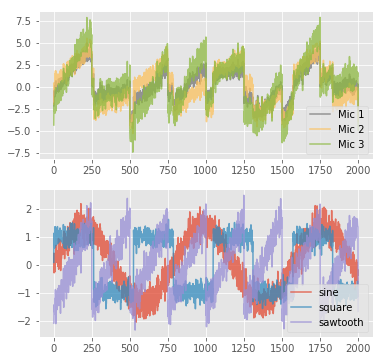

In [10]:
fig, (mixed_ax, originals_ax) = plt.subplots(nrows=2, figsize=(6, 6))
for idx, color in enumerate(('C3', 'C4', 'C5')):
    mixed_ax.plot(X[:,idx], label='Mic {}'.format(idx + 1), color=color, alpha=0.75)
mixed_ax.legend()
for idx, label in enumerate(('sine', 'square', 'sawtooth')):
    originals_ax.plot(S[:,idx], label=label, alpha=0.75)
originals_ax.legend()

Let's try applying PCA, knowing we expect 3 components:

In [11]:
pca = decomposition.PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

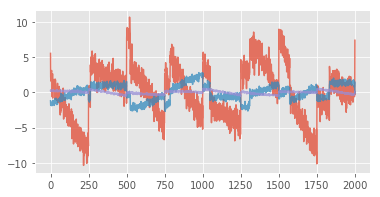

In [12]:
fig, pca_ax = plt.subplots(figsize=(6, 3))
for idx in range(3):
    pca_ax.plot(H[:,idx], alpha=0.75)

Not quite what we had in mind.

How does ICA fare?

In [13]:
ica = decomposition.FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals

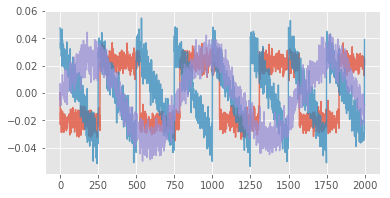

In [14]:
fig, ica_ax = plt.subplots(figsize=(6, 3))
for idx in range(3):
    ica_ax.plot(S_[:,idx], alpha=0.75)

Not in the same _order_, but they certainly look like our three input signals!

It's not a clear win for dimensionality reduction, but the components it recovers have nice properties for _blind source separation_. As explained in the `scikit-learn` docs:

> Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. [...] Typically, ICA is not used for reducing dimensionality but for separating superimposed signals.

# Manifold learning

PCA is well-suited to datasets where a linear combination of components can describe each datum. However, as we know, features in astronomical observations posess nonlinear characteristics.

One example is the broadening of spectral lines. The amplitude of a component encoding a spectral feature cannot encode its broadening, and to accurately capture this information you'd need a large number of components _per line_.

Manifold learning uses less-strong assumptions about the underlying surface or manifold where features lie, causing a corresponding increase in computational complexity in exchange for better reconstruction from fewer components.

### Data cleaning

A brief digression: machine learning techniques cannot get you out of cleaning up your data. The textbook examples use Jake's pre-interpolated spectra, which lets us pretend we live in a world of nicely regular data. However, if you wanted to amend this code to analyze SDSS stellar spectra you'd have to:

  * Query SDSS
  * Retrieve FITS spectra
  * Extract coadded $(\log \lambda,\ \mathit{flux})$ arrays
  * Resample spectra to common wavelength sampling
  * Truncate to overlapping wavelength region
  * Interpolate over any data quality issues

Before you had something the right shape to stick into a `scikit-learn` algorithm. (Not that I tried this while preparing the lecture, or anything.)

Alternatively, you can generate fake data and use it to explore the behavior of algorithms. This will allow you to obtain both an intuition for their operation, and a false sense of security that you will be able to apply the same analysis to real data!

## Local Linear Embedding

> "The preservation of locality in LLE enables nonlinear features within a spectrum (e.g. variation in the width of an emission line) to be captured with fewer components."

— Ivezić et al. "Data Mining and Machine Learning in Astronomy"

Leaving aside the mechanics of _how_ exactly this is accomplished, this algorithm obtains a matrix that transforms $K$-dimensional data into $d$ dimensions (where $d \lt K$) in such a way that distances from a point to its nearest neighbors are preserved.

If you think about it, this is a clever way to "unwrap" a nonlinear manifold: simply require points that are adjacent before the unwrapping to still be adjacent afterwards. (While being careful to define what you mean by "points", "adjacent", "unwrapping", and other such nontechnical terms.)

To demonstrate, I turn to the deliciously named [sklearn.datasets.make_swiss_roll](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_swiss_roll.html#sklearn.datasets.make_swiss_roll) function.

![Swiss roll](http://www.fnstatic.co.uk/images/content/video/raspberry-swiss-roll.jpg)

(Following example based on [Swiss roll reduction with LLE](http://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html#sphx-glr-auto-examples-manifold-plot-swissroll-py) by [Fabian Pedregosa](mailto:fabian.pedregosa@inria.fr) under the BSD 3 clause license, &copy; INRIA 2011.)

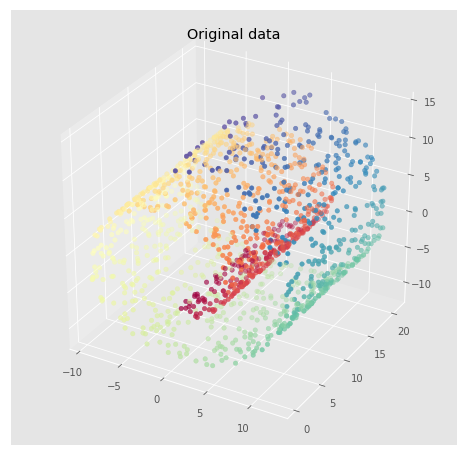

In [15]:
from sklearn import manifold, datasets
X, color = datasets.samples_generator.make_swiss_roll(
    n_samples=1500,
    noise=0.0
)
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Original data")

Now we use [sklearn.manifold.locally_linear_embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html#sklearn.manifold.locally_linear_embedding) to compute the embedding:

Computing LLE embedding
Done. Reconstruction error: 1.0266e-07


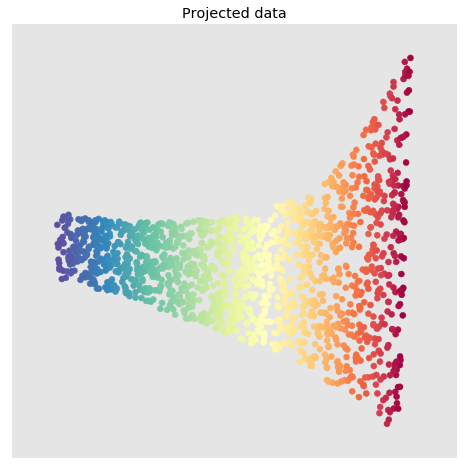

In [16]:
print("Computing LLE embedding")
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12,
                                             n_components=2)
print("Done. Reconstruction error: %g" % err)

#----------------------------------------------------------------------
# Plot result

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data')
plt.show()

## IsoMap

Since the text spends little time on the differences between LLE and IsoMap, neither will I. The astronomical applications are broadly similar: when you suspect data lies on some (nonlinear) manifold.

The computational complexity of IsoMap is $O[D \log(k) N \log(N)] + O[N^2(k + \log(N))] + O[d N^2]$.

Where $N$ is the number of training data points, $D$ is the input dimension, $k$ is the number of nearest neighbors, and $d$  the output dimension.

By comparison, LLE is $O[D \log(k) N \log(N)] + O[D N k^3] + O[d N^2]$.

So, if they provide equal performance (in terms of their ability to recover a reasonable projection), the decision should be motivated by whether $D N k^3 \lt N^2 (k + \log N)$ (if true, go with LLE).

# Compare and contrast

The sort version: It kind of depends on what you want. ICA is the only algorithm we covered for unmixing of truly independent signals (the "cocktail party problem"), but does not offer advantages over PCA in dimensionality reduction. If you suspect your data lie on a lower-dimensional manifold, LLE and IsoMap will recover it.

The really short version: Use PCA, or failing that, the algorithm with the smallest [Big-_O_ complexity](https://en.wikipedia.org/wiki/Big_O_notation) you can get away with.

*Table 7.1, Ivezi&#263; et al.* Summary of the practical properties of the main dimensionality reduction techniques
<table>
    <tr><th>Method</th><th>Accuracy</th><th>Interpretability</th><th>Simplicity</th><th>Speed</th></tr>
    <tr><td>Principal component analysis</td><td>High</td><td>High</td><td>High</td><td>High</td></tr>
    <tr><td>Locally linear embedding</td><td>High</td><td>Medium</td><td>High</td><td>Medium</td></tr>
    <tr><td>Nonnegative matrix factorization</td><td>High</td><td>High</td><td>Medium</td><td>Medium</td></tr>
    <tr><td>Independent component analysis</td><td>Medium</td><td>Medium</td><td>Low</td><td>Low</td></tr>
</table>